In [1]:
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Подход 1: градиентный бустинг "в лоб"
## 1. Считайте таблицу с признаками из файла features.csv
Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [2]:
df = pd.read_csv('features.csv', index_col='match_id')
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB


In [4]:
df.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,...,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,...,1.155609,0.813459,0.710122,40.701397,715.806850,0.499660,853.921365,851.009148,27.871645,27.064873
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-84.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,...,3.000000,2.000000,0.000000,-31.000000,1818.000000,0.000000,36.000000,256.000000,3.000000,3.000000
50%,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,...,3.000000,2.000000,1.000000,-16.000000,2268.000000,1.000000,1824.000000,1798.000000,63.000000,60.000000
75%,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,...,4.000000,3.000000,1.000000,8.000000,2778.000000,1.000000,1974.000000,1974.000000,63.000000,63.000000
max,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,...,9.000000,9.000000,13.000000,300.000000,8452.000000,1.000000,2047.000000,2047.000000,63.000000,63.000000


In [5]:
df.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'],
        axis=1, inplace=True)

##  2. Проверьте выборку на наличие пропусков с помощью функции count(), которая       для каждого столбца показывает число   заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [6]:
(df.shape[0] - df.count())[df.shape[0] - df.count() > 0].sort_values(ascending=False)/len(df)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

# Признаки, имеющие пропуски:
1. first_blood_player2 - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев.
2. radiant_flying_courier_time - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры.
3. dire_flying_courier_time - аналогично radiant_flying_courier_time.
4. first_blood_time - в 20% случаев первой крови нет в первые 5 минут игры.
5. first_blood_team - аналогично first_blood_time.
6. first_blood_player1 - аналогично first_blood_time.
7. dire_bottle_time - в 16% случаев команда не приобретает предмет "bottle" в первые 5 минут игры.
8. radiant_bottle_time - аналогично dire_bottle_time.
9. radiant_first_ward_time - очень редкое явление, в 1% случаев команда не ставит "наблюдателя" в первые 5 минут игры.
10. dire_first_ward_time - аналогично radiant_first_ward_time.
11. radiant_courier_time - самое редкое явление, в 0.5% случаев команда не приобретает предмет "courier" в первые 5 минут игры.
12. dire_courier_time - аналогично radiant_courier_time.

## 3. Замените пропуски на нули с помощью функции fillna(). 
На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [7]:
df.fillna(0, inplace=True)

## 4. Какой столбец содержит целевую переменную? Запишите его название.

In [8]:
print(df.columns[-1])

radiant_win


## 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". 

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?


In [9]:
X_train = df.drop('radiant_win', axis = 1)
y_train = df['radiant_win']

In [12]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)
res_cv_score = []
times = []
trees = [10, 20, 30, 40, 50, 100]
for num_trees in trees:
        print('Number of trees: {}'.format(num_trees))
        start_time = datetime.datetime.now()
        res = cross_val_score(GradientBoostingClassifier(n_estimators=num_trees, random_state=1),
                              X_train, y_train, cv=kf, scoring="roc_auc", n_jobs=-1).mean()
        res_cv_score.append(res)
        print('Cross validation quality: {}'.format(res))
        time = datetime.datetime.now() - start_time
        times.append(time)
        print('Time elapsed: {}'.format(time))
        print()


Number of trees: 10
Cross validation quality: 0.66483292280491
Time elapsed: 0:00:25.400281

Number of trees: 20
Cross validation quality: 0.6821140369500348
Time elapsed: 0:00:49.440169

Number of trees: 30
Cross validation quality: 0.6896947542059906
Time elapsed: 0:01:09.898460

Number of trees: 40
Cross validation quality: 0.6939341916023564
Time elapsed: 0:01:29.722820

Number of trees: 50
Cross validation quality: 0.6971139526079494
Time elapsed: 0:01:53.349327

Number of trees: 100
Cross validation quality: 0.7062113460515892
Time elapsed: 0:03:39.368451



In [30]:
times[0].seconds

25

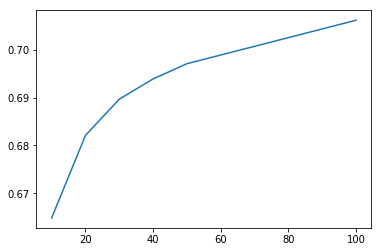

In [33]:
plt.plot(trees, res_cv_score)

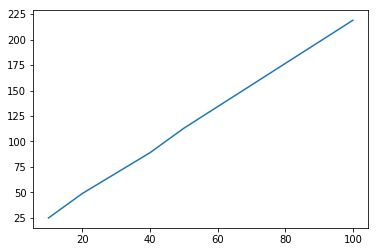

In [34]:
time_sec = []
for t in times:
    time_sec.append(t.seconds)
plt.plot(trees, time_sec)

# Отчет GradientBoosting

## 1. Признаки, имеющие пропуски:
1. first_blood_player2 - первое убийство может быть совершено одним игроком, это достаточно частое явление и происходит в 45% случаев.
2. radiant_flying_courier_time - в 28% случаев команда не покупает "flying_courier" в первые 5 минут игры.
3. dire_flying_courier_time - аналогично radiant_flying_courier_time.
4. first_blood_time - в 20% случаев первой крови нет в первые 5 минут игры.
5. first_blood_team - аналогично first_blood_time.
6. first_blood_player1 - аналогично first_blood_time.
7. dire_bottle_time - в 16% случаев команда не приобретает предмет "bottle" в первые 5 минут игры.
8. radiant_bottle_time - аналогично dire_bottle_time.
9. radiant_first_ward_time - очень редкое явление, в 1% случаев команда не ставит "наблюдателя" в первые 5 минут игры.
10. dire_first_ward_time - аналогично radiant_first_ward_time.
11. radiant_courier_time - самое редкое явление, в 0.5% случаев команда не приобретает предмет "courier" в первые 5 минут игры.
12. dire_courier_time - аналогично radiant_courier_time.

## 2. Cтолбец, содержащий целевую переменную, называется  radiant_win

## 3. Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 1мин. 9 сек. Качество по метрике AUC-ROC получилось 0,69.

## 4.  Показатель метрики AUC-ROC  для 200 деревьев составляет 0,71, что на ~4% больше, чем для 30 деревьев.  Для достижения большего качества имеет смысл использовать более 30 деревьев. Для ускорения обучения можно использовать не всю выборку, а некоторое ее подмножество — например, половину объектов. Также можно уменьшить глубину деревьев (max_depth).

# Подход 2: логистическая регрессия

## 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга.

In [41]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [37]:
res_cv_score_lr = []
times_lr = []
hyp_par = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
for c in hyp_par:
    print('C: {}'.format(c))
    start_time = datetime.datetime.now()
    res = cross_val_score(LogisticRegression(C=c, random_state=1), X_train_scaled, y_train, cv=kf, scoring="roc_auc", n_jobs=-1).mean()
    res_cv_score_lr.append(res)
    print('Cross validation quality: {}'.format(res))
    time = datetime.datetime.now() - start_time
    times_lr.append(time)
    print('Time elapsed: {}'.format(time))
    print()

C: 0.0001
Cross validation quality: 0.7112865148335556
Time elapsed: 0:00:12.141361

C: 0.001
Cross validation quality: 0.7162096360086553
Time elapsed: 0:00:14.449532

C: 0.01
Cross validation quality: 0.7163757959125769
Time elapsed: 0:00:19.052161

C: 0.1
Cross validation quality: 0.7163509299301707
Time elapsed: 0:00:19.409159

C: 1
Cross validation quality: 0.7163472703068168
Time elapsed: 0:00:19.552215

C: 10
Cross validation quality: 0.7163470734968606
Time elapsed: 0:00:19.658001

C: 100
Cross validation quality: 0.716347075646171
Time elapsed: 0:00:21.388876

C: 1000
Cross validation quality: 0.7163470904820135
Time elapsed: 0:00:19.106063



Лучшее значение метрики качества на кросс валидации 0,72 при С=0,01. Логистистическая регрессия работает в 3,5 раза быстрее 
градиентного бустинга на 30 деревьях и в 10 раз быстрее, чем на 100 деревьях. Логистическая регрессия дает схожий результат
с ГБ на 100 деревьях. Признаки скорее всего линейно связаны с целевой переменной и поэтому ЛР дает такой же результат как и более сложная модель.

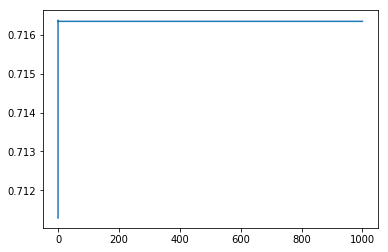

In [38]:
plt.plot(hyp_par, res_cv_score_lr)

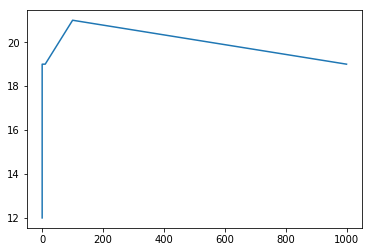

In [39]:
time_sec_lr = []
for t in times_lr:
    time_sec_lr.append(t.seconds)
plt.plot(hyp_par, time_sec_lr)

## 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей.

Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [42]:
columns_1_6 = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
columns_cat_to_drop = ["lobby_type"] + columns_1_6
X_train_scaled.drop(columns_cat_to_drop, axis=1, inplace=True)

In [44]:
res_cv_score_lr = []
times_lr = []
hyp_par = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
for c in hyp_par:
    print('C: {}'.format(c))
    start_time = datetime.datetime.now()
    res = cross_val_score(LogisticRegression(C=c, random_state=1), X_train_scaled, y_train, cv=kf, scoring="roc_auc", n_jobs=-1).mean()
    res_cv_score_lr.append(res)
    print('Cross validation quality: {}'.format(res))
    time = datetime.datetime.now() - start_time
    times_lr.append(time)
    print('Time elapsed: {}'.format(time))
    print()

C: 0.0001
Cross validation quality: 0.7112629500700418
Time elapsed: 0:00:14.526850

C: 0.001
Cross validation quality: 0.7162333103715236
Time elapsed: 0:00:13.334386

C: 0.01
Cross validation quality: 0.7164088702736156
Time elapsed: 0:00:16.188225

C: 0.1
Cross validation quality: 0.716383801538205
Time elapsed: 0:00:16.989784

C: 1
Cross validation quality: 0.7163803390297804
Time elapsed: 0:00:17.754035

C: 10
Cross validation quality: 0.7163798497335823
Time elapsed: 0:00:17.305583

C: 100
Cross validation quality: 0.7163796823834381
Time elapsed: 0:00:16.952222

C: 1000
Cross validation quality: 0.7163796929771316
Time elapsed: 0:00:16.645428



Лучшее значение метрики качества на кросс валидации без категориальных признаков 0,72 при С=0,01. Удаление категориальных признаков не повлияло на качество предсказания- можем сделать вывод, что они не влияют на результат.

## 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. 

Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [45]:
unique = np.unique(df[columns_1_6].values.ravel())
print('Количество уникальных героев: {}'.format(len(unique)))

Количество уникальных героев: 108


## 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях.
Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [53]:
X_pick = np.zeros((df.shape[0], max(unique)))
for i, match_id in enumerate(df.index):
    for p in range(1, 6):
        X_pick[i, df.loc[match_id, f"r{p}_hero"] - 1] = 1
        X_pick[i, df.loc[match_id, f"d{p}_hero"] - 1] = -1
X_pick = pd.DataFrame(X_pick, index=df.index, columns=[f"hero_{i}" for i in range(max(unique))])
X_train_scaled_bag = pd.concat([X_train_scaled, X_pick], axis=1)

## 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [54]:
res_cv_score_lr = []
times_lr = []
hyp_par = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
for c in hyp_par:
    print('C: {}'.format(c))
    start_time = datetime.datetime.now()
    res = cross_val_score(LogisticRegression(C=c, random_state=1), X_train_scaled_bag, y_train, cv=kf, scoring="roc_auc", n_jobs=-1).mean()
    res_cv_score_lr.append(res)
    print('Cross validation quality: {}'.format(res))
    time = datetime.datetime.now() - start_time
    times_lr.append(time)
    print('Time elapsed: {}'.format(time))
    print()

C: 0.0001
Cross validation quality: 0.7250091276027153
Time elapsed: 0:00:30.600941

C: 0.001
Cross validation quality: 0.7462121394980905
Time elapsed: 0:00:16.890262

C: 0.01
Cross validation quality: 0.7516515685079631
Time elapsed: 0:00:25.751818

C: 0.1
Cross validation quality: 0.7518733239466562
Time elapsed: 0:00:35.845830

C: 1
Cross validation quality: 0.7518569888921663
Time elapsed: 0:00:37.818050

C: 10
Cross validation quality: 0.7518557503285759
Time elapsed: 0:00:38.610209

C: 100
Cross validation quality: 0.751855462368788
Time elapsed: 0:00:36.643918

C: 1000
Cross validation quality: 0.7518556106003842
Time elapsed: 0:00:36.566689



Лучшее значение метрики качества на кросс валидации  0,75 при С=0,1. После добавления информации о героях качество
улучшилось. Это можно обьяснить тем, что трансформировав категориальные признаки мы добавили новую информацию в датасет
вместо 'шума'.

## 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). 

Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [55]:
lr = LogisticRegression(C=0.1, random_state=1)
lr.fit(X_train_scaled_bag, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
df_test = pd.read_csv('features_test.csv', index_col="match_id")
df_test.fillna(0, inplace=True)

X_test_scaled = pd.DataFrame(scaler.fit_transform(df_test), index=df_test.index, columns=df_test.columns)
X_test_scaled.drop(columns_cat_to_drop, axis=1, inplace=True)

X_pick_test = np.zeros((df_test.shape[0], max(unique)))
for i, match_id in enumerate(df_test.index):
    for p in range(1, 6):
        X_pick_test[i, df_test.loc[match_id, f"r{p}_hero"] - 1] = 1
        X_pick_test[i, df_test.loc[match_id, f"d{p}_hero"] - 1] = -1
X_pick_test = pd.DataFrame(X_pick_test, index=df_test.index, columns=[f"hero_{i}" for i in range(max(unique))])    

X_test_scaled_bag = pd.concat([X_test_scaled, X_pick_test], axis=1)

In [71]:
pred = lr.predict_proba(X_test_scaled_bag)[:, 1]
print(pred)

[0.82466532 0.75716467 0.18778593 ... 0.234004   0.62470705 0.4270961 ]


In [73]:
print(min(pred), max(pred))

0.008580621772195629 0.996458657130964


Значения разные и находятся в интервале [0,1]

#  Отчет Linear Regression

1. Лучшее значение метрики качества на кросс валидации 0,72 при С=0,01. Логистистическая регрессия работает в 3,5 раза быстрее 
   бустинга на 30 деревьях и в 10 раз быстрее, чем на 100 деревьях. Логистическая регрессия дает схожий результат
   с ГБ на 100 деревьях. Признаки скорее всего линейно связаны с целевой переменной и поэтому ЛР дает такой же результат как и    более сложная модель.
2. Лучшее значение метрики качества на кросс валидации без категориальных признаков 0,72 при С=0,01. Удаление категориальных      признаков не повлияло на качество предсказания- можем сделать вывод, что они не влияют на результат. Кат. призн. - шум.
3. Количество уникальных героев: 108
4. Лучшее значение метрики качества на кросс валидации 0,75 при С=0,1. После добавления информации о героях качество    улучшилось. Это можно обьяснить тем, что трансформировав категориальные признаки мы добавили новую информацию в датасет
   вместо 'шума'.
5. 0.008580621772195629 0.996458657130964